# Spectogram creation with segmentations

The first part of this code creates a class called AudioWorker that encompasses various methods for working with the recordings. In particular, we import the `librosa` library to create mel-scaled spectograms (on the Mel scale and corresponding spectograms, see e.g. https://readmedium.com/making-sense-of-audio-features-with-librosa-part-3-spectrograms-8a80b7f9acdf). We segment the resulting spectograms according to the onset and offset of strophes, i.e. when the recorded bird of interest sings. Thus we obtain the times of all on- and offsets for each individual as well as the durations of all of its calculated stropes/pauses.

In [2]:
import os 
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa, soundfile as sf

In [3]:
ABS_PATH = os.path.dirname(os.path.dirname(os.path.abspath("")))
SRC_PATH = os.path.join(ABS_PATH, "static", "audios", "0_src")
OUT_PATH = os.path.join(ABS_PATH, "static", "audios", "1_noise_reduced")

In [ ]:
class AudioWorker():
    
    def __init__(self, audio_path):
        self.audio_path = audio_path
        
        self.sample_rate, self.samples = wavfile.read(audio_path)
        if len(self.samples.shape)==2:
            self.samples = np.array(self.samples[:,0], dtype=float)     
        else: self.samples = np.array(self.samples, dtype=float)
        
        
    def get_mel_specs(self):
        specs = librosa.feature.melspectrogram(y=self.samples, sr=self.sample_rate, n_mels=128, fmax=20000) 
        specs_dB = librosa.power_to_db(specs, ref=np.max)
        return specs_dB
    
    
    def segmentation(self, specs, save_fig=False):
        specs_maxs = specs.argmax(axis=0)
        specs_maxs_ma = np.convolve(specs_maxs, np.ones(3), mode="same")        # ma = moving average
        cut_indices = np.where(specs_maxs_ma>specs_maxs_ma.mean(), 1, 0)
        
        cut_indices = np.convolve(cut_indices, np.ones(10), mode="same")        # erosion
        cut_indices = np.where(cut_indices==10, 1, 0)                       
        cut_indices = np.convolve(cut_indices, np.ones(80), mode="same")        # dilation -> establishes padding after onset and before offset, remaining signals are elongated to be at least 80 "segments" long
        cut_indices = np.where(cut_indices>=1, 1, 0)
        
        # To get on and offsets
        diff = cut_indices[1:] - cut_indices[:-1]
        offsets = np.where(diff==-1)
        onsets = np.where(diff==1)
        
        # Just for plotting
        cut_indices = np.where(cut_indices>=1)
        
        
        fig, ax = plt.subplots(nrows=1, figsize=(16,4), sharex=True)

        times = librosa.times_like(specs, sr=self.sample_rate)
        img = librosa.display.specshow(specs,
                                        x_axis='time', y_axis='mel', sr=self.sample_rate, fmax=20000, ax=ax)
        ax.vlines(times[cut_indices], 0, 20000, alpha=0.05, color="y")
        ax.vlines(times[onsets], 0, 20000, color="g", alpha=0.7)
        ax.vlines(times[offsets], 0, 20000, color="r", alpha=0.3)
        if save_fig: plt.savefig(f"{os.path.join(OUT_PATH, os.path.basename(self.audio_path))}-segmentation.png")
        
        intervals = (times[onsets], times[offsets])
        onsets, offsets = list(intervals[0]), list(intervals[1])

        if onsets[0] > offsets[0]: onsets.insert(0,0)
       
        singing = [(offset-onset) for onset, offset in zip(onsets, offsets)]
        pauses = [(onset-offset) for onset, offset in zip(onsets[1:], offsets)]   

        ax.set_title(f"{os.path.basename(self.audio_path)}     s_mean:{np.array(singing).mean():.1f}s     p_mean: {np.array(pauses).mean():.1f}s")

        return onsets, offsets, singing, pauses
    
    
    def spec_freq_peaks(self, specs, save_fig=False):
        
    #     fig, ax = plt.subplots(nrows=1, figsize=(16,4), sharex=True)
    #     img = librosa.display.specshow(specs,
    #                                     x_axis='time', y_axis='mel', ax=ax, sr=self.sample_rate)
    #     ax.set_title("Mel spectogram")
    #     times = librosa.times_like(specs, sr=self.sample_rate)

        specs_maxs = specs.argmax(axis=0)
        specs_maxs_ma = np.convolve(specs_maxs, np.ones(10), mode="same")
        ax.vlines(times[np.where(specs_maxs_ma>specs_maxs_ma.mean())], 0, 1000, color="r")
        # ax.vlines(times[np.where(spec_diffs.mean(axis=0)>spec_diffs.mean())], 0, 1000)
        ax.scatter(times, specs_maxs**2, s=1, color="y", alpha=1)

        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        plt.suptitle(os.path.basename(self.audio_path))
        if save_fig: plt.savefig(f"{os.path.join(OUT_PATH, os.path.basename(self.audio_path))}-freq_peaks.png")
        

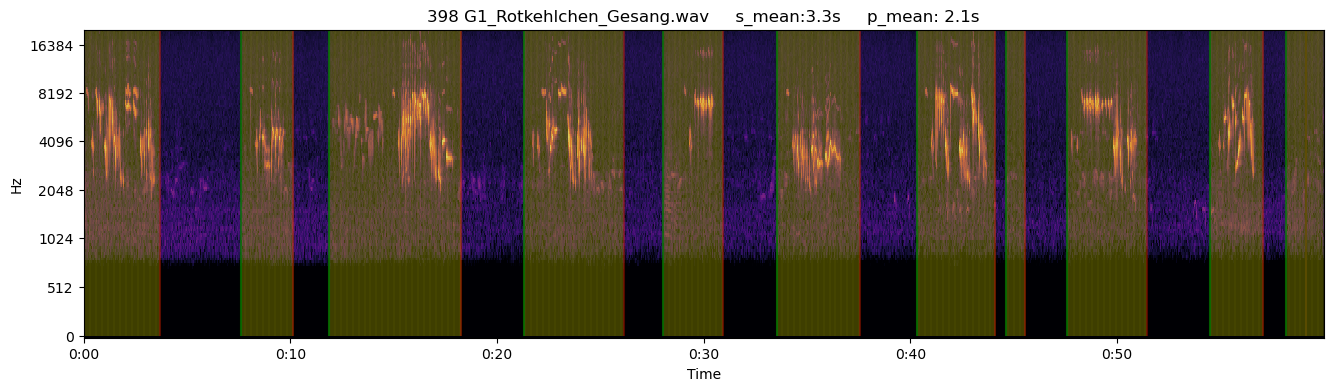

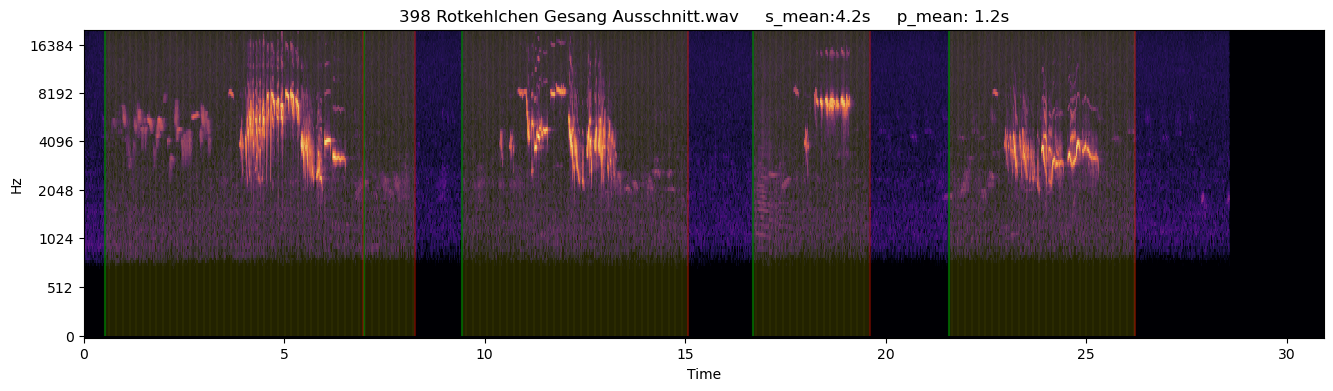

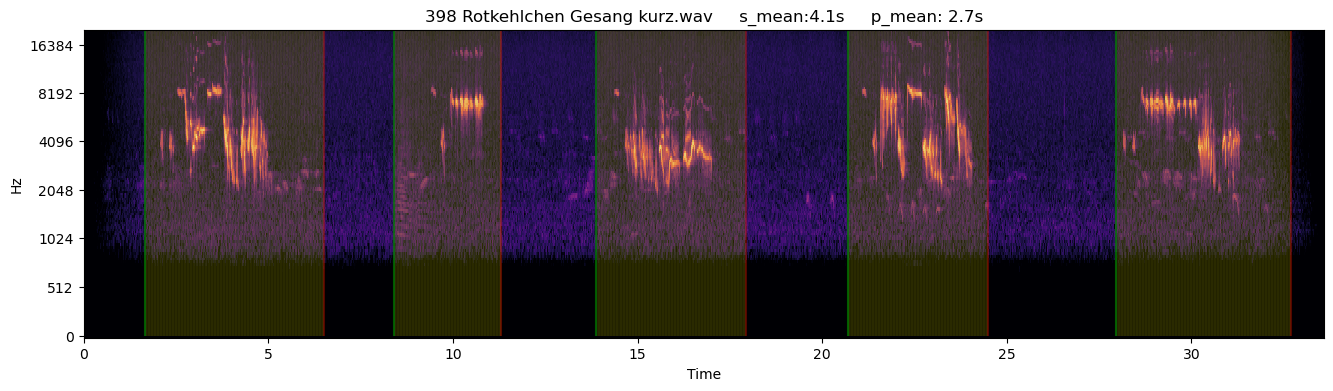

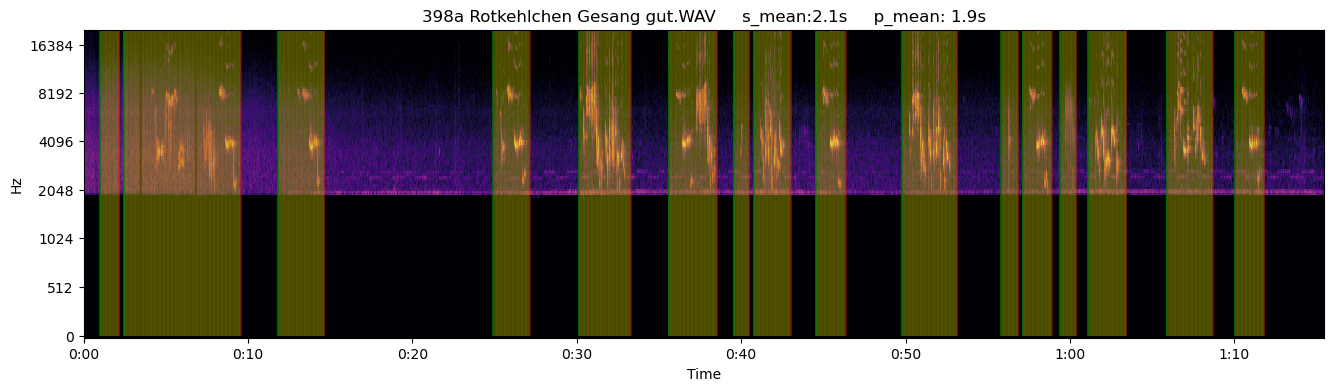

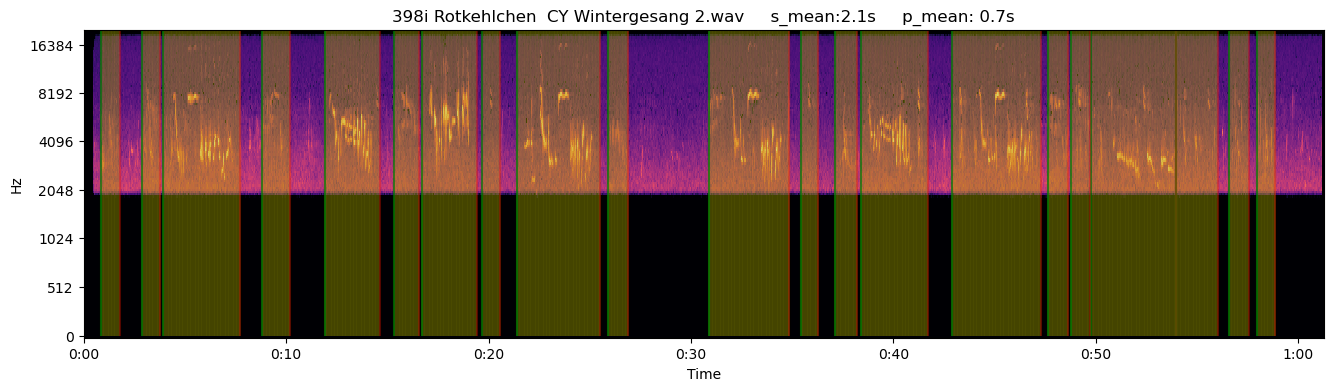

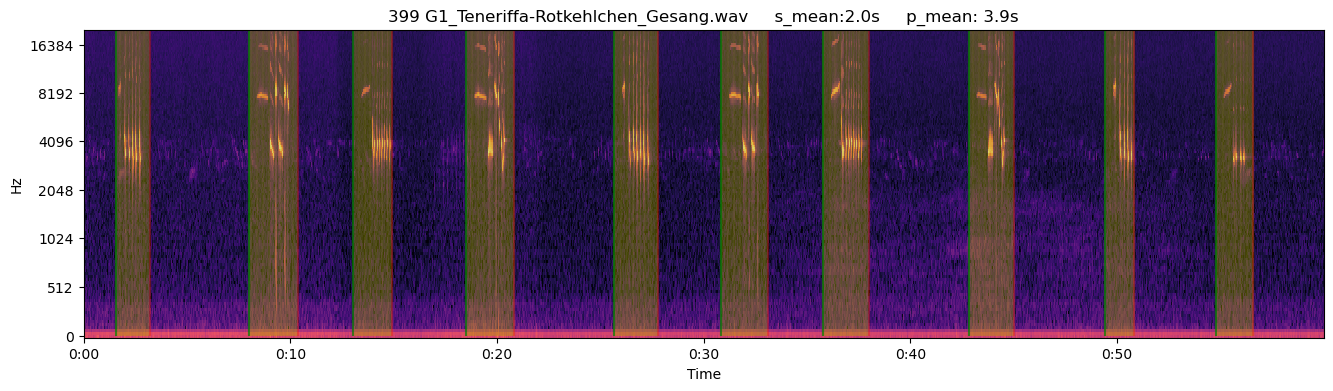

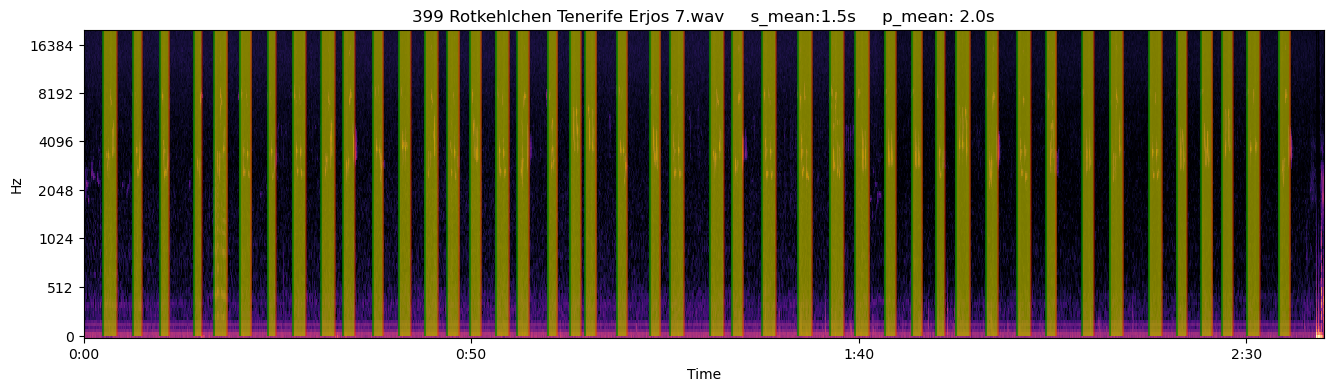

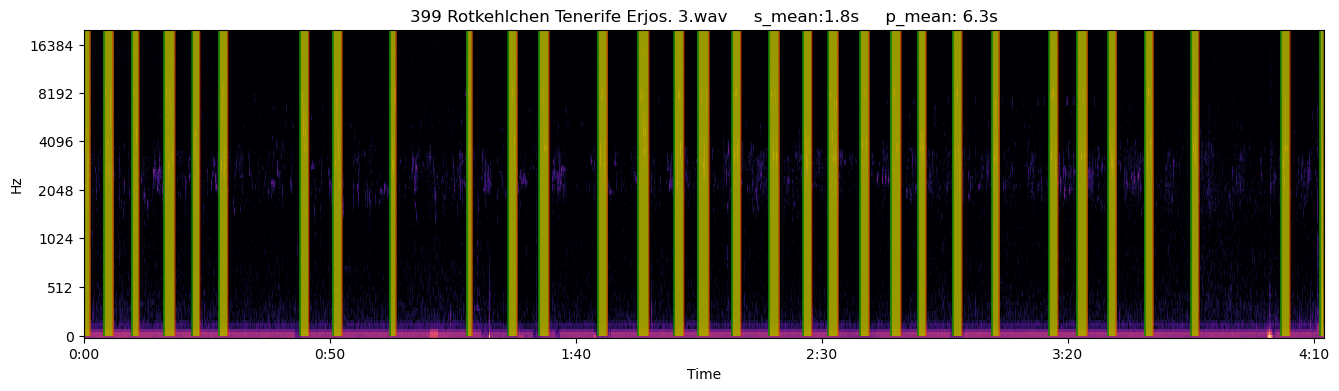

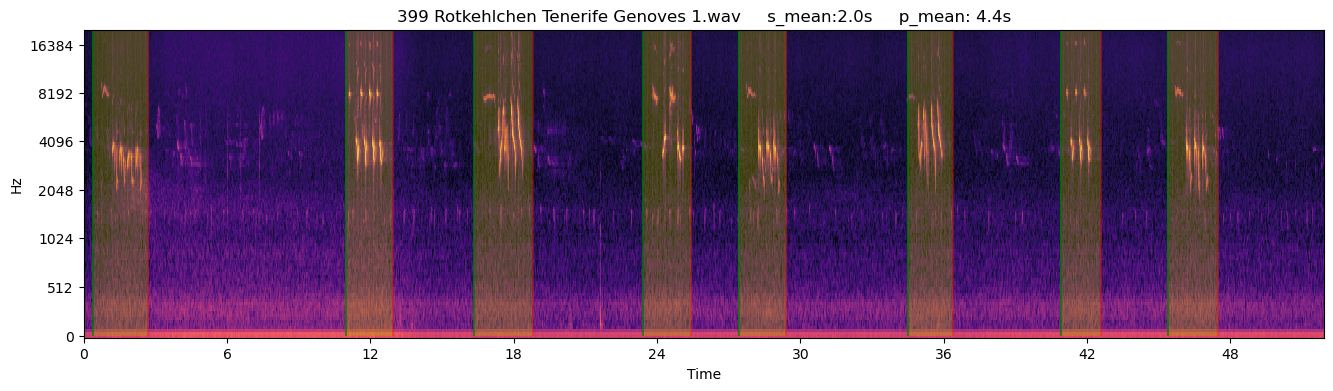

In [30]:
intervals_dict = {}    
for fname in os.listdir(SRC_PATH)[:]:
    if fname.lower().endswith(".wav"):
        audio_path = os.path.join(SRC_PATH, fname)
        audioWorker = AudioWorker(audio_path=audio_path)
        specs = audioWorker.get_mel_specs()
        # audioWorker.plot_mel_spec(specs, save_fig=False)
        intervals = audioWorker.segmentation(specs, save_fig=False)    
        fname = fname.removesuffix('.wav')
        intervals_dict[fname] = intervals

The resulting plots should for the most part show well-segmented spectrograms. However, the segmentation of some strophes by continental robins is choppy—a result of our implemented segmentation function which is not sufficiently fine-grained and robust enough to ensure a consistently coherent segmentation. This is especially evident when using it on some noisier audio files that have been moved to a different folder on Nextcloud ('0.1_src_difficult').   

In [ ]:
#print(len(intervals_dict['Rotkehlchen Tenerife Erjos. 3']))  # unclosed segments are not counted
#specs.shape

4


In [ ]:
mel_freqs_hz = librosa.mel_frequencies(
                    n_mels=128,
                    fmin=0,
                    fmax=20000,
                    htk=False)

mel_freqs_hz[100]

# Mean and variance of strophes and pauses

The following 

In [6]:
import pandas as pd

In [39]:
# initialise lists for all values of interest
bird_files = []
singing_mean = []
singing_var = []
pauses_mean = []
pauses_var = []
species = []

# iterate over dict keys to get and calculate values, then append them to respective list
for bird in intervals_dict.keys():
    
    singing = intervals_dict[bird][2]
    pauses = intervals_dict[bird][3]

    bird_files.append(bird)
    singing_mean.append(np.array(singing).mean())
    singing_var.append(np.array(singing).var())
    pauses_mean.append(np.array(pauses).mean())
    pauses_var.append(np.array(pauses).var())
    species.append(bird.split(" ")[0][:3])          # species represented by 3-digit number, slicing to make sure that we only get the number and no further identifiers

# turn filled lists into pd series
bird_files = pd.Series(bird_files)
singing_mean = pd.Series(singing_mean)
singing_var= pd.Series(singing_var)
pauses_mean = pd.Series(pauses_mean)
pauses_var = pd.Series(pauses_var)
species = pd.Series(species)

# create df from panda series above
df_birds = pd.DataFrame({'bird_files': bird_files,
                        'singing_mean': singing_mean,
                        'singing_var': singing_var,
                        'pauses_mean': pauses_mean,
                        'pauses_var': pauses_var,
                        'species': species})

In [40]:
df_birds = df_birds.set_index('bird_files')
df_birds

,singing_mean,singing_var,pauses_mean,pauses_var,species
bird_files,,,,,
398 G1_Rotkehlchen_Gesang,3.316232,2.324818,2.060243,1.260114,398
398 Rotkehlchen Gesang Ausschnitt,4.172626,3.493075,1.207438,0.538829,398
398 Rotkehlchen Gesang kurz,4.063492,0.495656,2.679002,0.311461,398
398a Rotkehlchen Gesang gut.WAV,2.122046,0.689662,1.918378,5.552010,398
398i Rotkehlchen CY Wintergesang 2,2.061206,1.762211,0.736533,0.742838,398
399 G1_Teneriffa-Rotkehlchen_Gesang,2.020136,0.091362,3.872572,0.738601,399
399 Rotkehlchen Tenerife Erjos 7,1.504811,0.050162,2.022296,0.426363,399
399 Rotkehlchen Tenerife Erjos. 3,1.778199,0.077928,6.326314,12.230947,399
399 Rotkehlchen Tenerife Genoves 1,2.041905,0.049921,4.391889,3.567113,399


In [68]:
import reprlib 

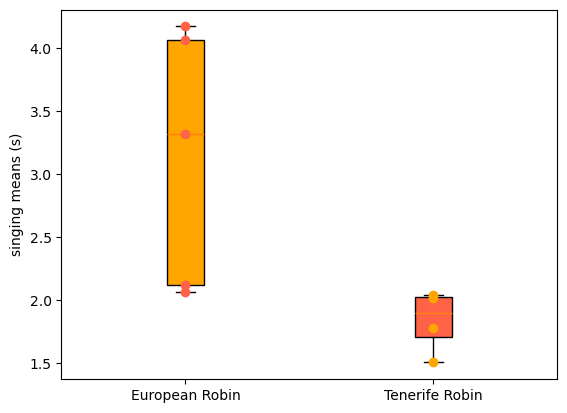

In [ ]:
df_398 = df_birds[df_birds['species'] == '398']
df_399 = df_birds[df_birds['species'] == '399']
singing_means = [
    df_398['singing_mean'].values,
    df_399['singing_mean'].values,
]

labels = ['European Robin', 'Tenerife Robin']
colors = ['orange', 'tomato']

fig, ax = plt.subplots()
ax.set_ylabel('singing means (s)')


bplot = ax.boxplot(singing_means,
                   patch_artist=True,  # fill with color
                   tick_labels=labels,
                   zorder=0)           # necessary because otherwise the scatter plot will be covered by the bp

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)


# Add Scatterplot on top
x_398 = np.ones(shape=(len(singing_means[0])))
x_399 = np.ones(shape=len(singing_means[1])) *2
plt.scatter(x_398, singing_means[0], color='tomato', zorder=10)
plt.scatter(x_399, singing_means[1], color="orange", zorder=10)


plt.show()
# display(filtered_df)

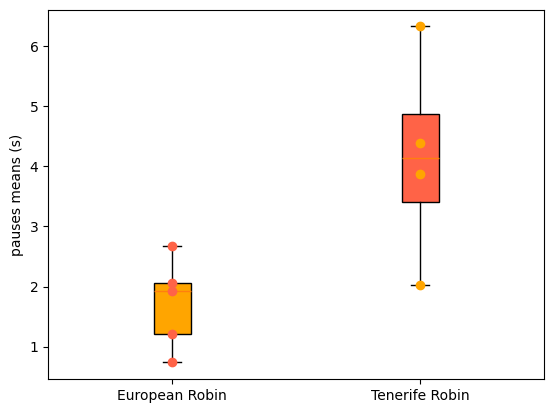

In [118]:
df_398 = df_birds[df_birds['species'] == '398']
df_399 = df_birds[df_birds['species'] == '399']
pauses_means = [
    df_398['pauses_mean'].values,
    df_399['pauses_mean'].values,
]

labels = ['European Robin', 'Tenerife Robin']
colors = ['orange', 'tomato']

fig, ax = plt.subplots()
ax.set_ylabel('pauses means (s)')


bplot = ax.boxplot(pauses_means,
                   patch_artist=True,  # fill with color
                   tick_labels=labels,
                   zorder=0)  

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)


# Add Scatterplot on top
x_398 = np.ones(shape=(len(pauses_means[0])))
x_399 = np.ones(shape=len(pauses_means[1])) *2
plt.scatter(x_398, pauses_means[0], color='tomato', zorder=10)
plt.scatter(x_399, pauses_means[1], color="orange", zorder=10)


plt.show()

In [95]:
singing_means

[array([3.3162317 , 4.17262585, 4.06349206, 2.12204586, 2.06120635]),
 array([2.02013605, 1.50481138, 1.77819911, 2.04190476])]

In [63]:
# means of the stats grouped by species 
species_singing_mean = round(df_birds.groupby('species')['singing_mean'].mean(), 3)
species_singing_var = round(df_birds.groupby('species')['singing_var'].mean(), 3)
species_pauses_mean = round(df_birds.groupby('species')['pauses_mean'].mean(), 3)
species_pauses_var = round(df_birds.groupby('species')['pauses_var'].mean(), 3)

#print(f"The singing mean for continental robins is {species_singing_mean.iloc[0]:.1f}s.")

# new df based on species
df_birds_species = pd.DataFrame({'singing_mean': species_singing_mean,
                                'singing_var': species_singing_var,
                                'pauses_mean': species_pauses_mean,
                                'pauses_var': species_pauses_var,
})

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

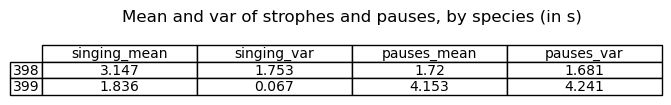

In [67]:
fig = plt.figure(figsize = (8, .2))
ax = fig.add_subplot(111)

#create table
ax.table(cellText = df_birds_species.values, rowLabels = df_birds_species.index, 
         colLabels = df_birds_species.columns, cellLoc='center')

#add title to table
ax.set_title('Mean and var of strophes and pauses, by species (in s)')

#turn axes off
ax.axis('off')

The variance for the pauses in both species is very high, almost as high or 